In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader 

from src.utils import VideoFolder, transforms_testing, mixup_cutmix_collate_func, transform_inference
from hf_pretrained_model import TemporalViTConfig, TemporalViTHF
from transformers import AutoModel, AutoConfig

In [2]:
AutoConfig.register('temporal-vit', TemporalViTConfig)
AutoModel.register(TemporalViTConfig, TemporalViTHF)

model = AutoModel.from_pretrained('detker/temporal-vit-85M', 
                                  trust_remote_code=True, 
                                  use_safetensors=True)
model

TemporalViTHF(
  (model): VisionTransformer(
    (patch_embd): PatchEmbedding(
      (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x EncoderBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (q): Linear(in_features=768, out_features=768, bias=True)
          (k): Linear(in_features=768, out_features=768, bias=True)
          (v): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_dropout): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (activation_f): GELU(approximate='none')
          (dropout1): D

In [4]:
CLIP_LOC = '../data/test'
N_FRAMES = 18
IMG_WH = 224

test_transforms = transforms_testing(img_wh=IMG_WH)
inference_transforms = transform_inference(img_wh=IMG_WH)
test_data = VideoFolder(path_to_data=CLIP_LOC, 
                        frames_n=N_FRAMES,
                        transform=test_transforms)
test_data_vis = VideoFolder(path_to_data=CLIP_LOC,
                            frames_n=N_FRAMES,
                            transform=inference_transforms)
perm = torch.randperm(len(test_data))
num_classes = len(test_data.idx2class.keys())
collate_fn = mixup_cutmix_collate_func()
test_loader = DataLoader(test_data, collate_fn=collate_fn, sampler=perm)
test_loader_vis = DataLoader(test_data_vis, collate_fn=collate_fn, sampler=perm)

test_loader_iterable = iter(test_loader)
test_loader_vis_iterable = iter(test_loader_vis)

In [9]:
def generate_plots(frames, ax, dim=3):
    for i in range(0,dim):
        for j in range(0,dim):
            ax[i,j].imshow(frames[2*i*dim+j].permute(1,2,0))
            
    plt.show() 

Label: TableTennisShot - TableTennisShot


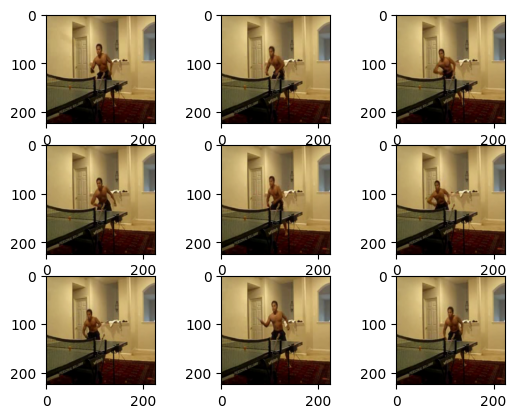

Predicted values:
Top 1: TableTennisShot
Top 5: ['TableTennisShot', 'CricketBowling', 'SoccerPenalty', 'BalanceBeam', 'BoxingSpeedBag']
Label: CliffDiving - CliffDiving


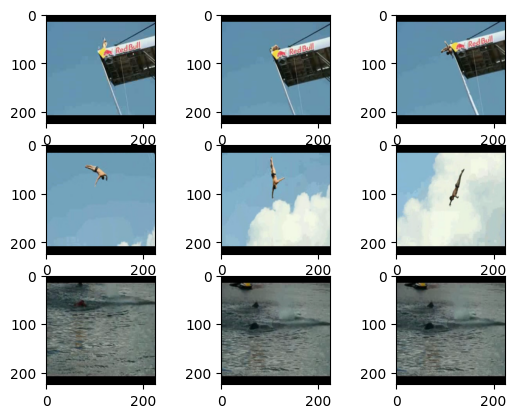

Predicted values:
Top 1: TableTennisShot
Top 5: ['TableTennisShot', 'CliffDiving', 'SkyDiving', 'FloorGymnastics', 'Billiards']
Label: Typing - Typing


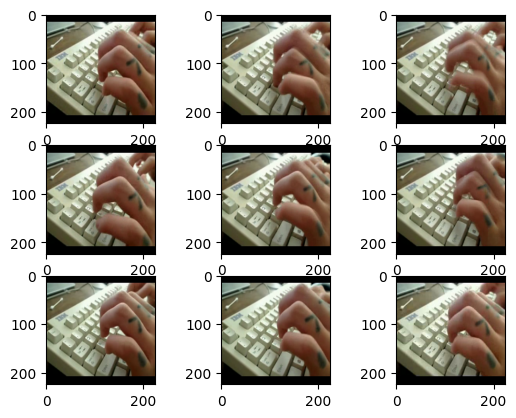

Predicted values:
Top 1: Typing
Top 5: ['Typing', 'Knitting', 'CuttingInKitchen', 'ShavingBeard', 'BrushingTeeth']
Label: Surfing - Surfing


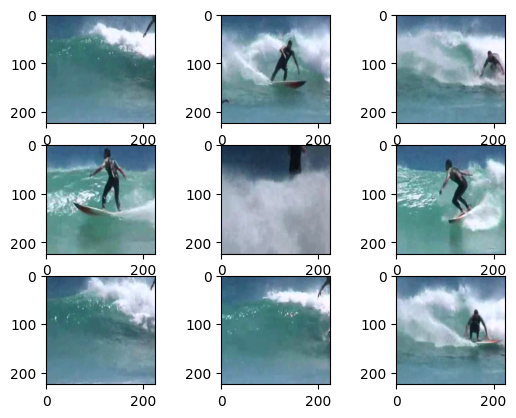

Predicted values:
Top 1: Surfing
Top 5: ['Surfing', 'SkyDiving', 'Skijet', 'Skiing', 'FrontCrawl']
Label: WallPushups - WallPushups


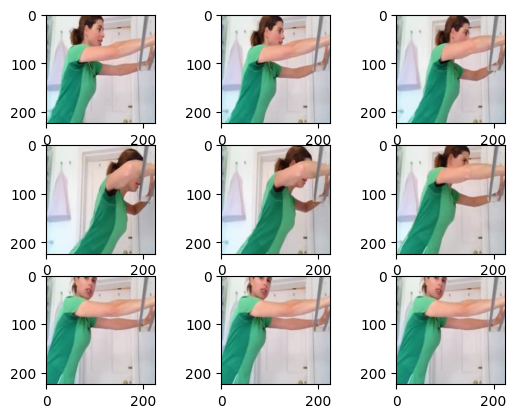

Predicted values:
Top 1: WallPushups
Top 5: ['WallPushups', 'Archery', 'HandstandPushups', 'HammerThrow', 'ThrowDiscus']


In [14]:
idx2class = test_data.idx2class
for _ in range(5):
    data = next(test_loader_iterable)
    data_vis = next(test_loader_vis_iterable)
    frames, lbl = data
    frames_vis, lbl_vis = data_vis
    
    print(f'Label: {idx2class[lbl.item()]} - {idx2class[lbl_vis.item()]}')
    dim=3 
    fig, ax = plt.subplots(dim, dim)
    generate_plots(frames_vis.squeeze(0), ax, dim=dim)

    with torch.no_grad():
        output = model(frames)
        
    probs = F.softmax(output, dim=-1)
    k = 5
    values, idxs = probs.topk(k=1, dim=-1)
    values_topk, idxs_topk = probs.topk(k=k, dim=-1)

    
    print('Predicted values:')
    print(f'Top 1: {idx2class[idxs.squeeze(0).item()]}')
    print(f'Top {k}: {[idx2class[idx] for idx in idxs_topk.squeeze(0).tolist()]}')
    